In [1]:
import sys
import os
import tqdm

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, os.path.abspath("../cli"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    run_beam,
    positions_line,
    positions_half_circle,
    calculate_coordinates_from_pos,
)
from simulation.plotting import plot_velocity, plot_attenuation
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)

### Functions and Source

In [2]:
def plot_snapshot_and_signal(
    snap: npt.NDArray,
    recording: npt.NDArray,
    model,
    outfile,
    source_coords=None,
    receiver_coords=None,
):
    fig, ax = plt.subplots(
        2,
        1,
        figsize=(10, 15),
        gridspec_kw={"width_ratios": [1], "height_ratios": [2, 1]},
    )
    snap_step = int(recording.shape[0] / snap.shape[0])
    domain_size = np.array(model.domain_size)
    extent = [
        model.origin[0],
        model.origin[0] + domain_size[0],
        model.origin[1] + domain_size[1],
        model.origin[1],
    ]
    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    field = model.vp.data[slices]
    ax[0].imshow(
        np.transpose(field),
        cmap="viridis",
        vmin=np.min(field),
        vmax=np.max(field),
        extent=extent,
    )

    if receiver_coords is not None:
        ax[0].scatter(
            receiver_coords[:, 0], receiver_coords[:, 1], s=25, c="green", marker="o"
        )
    if source_coords is not None:
        ax[0].scatter(
            source_coords[:, 0], source_coords[:, 1], s=25, c="red", marker="o"
        )

    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap))) / 2
    snap = snap[:, model.nbl : -model.nbl, model.nbl : -model.nbl]
    matrice = ax[0].imshow(
        snap[0, :, :].T,
        vmin=-ampl_limit,
        vmax=ampl_limit,
        cmap="seismic",
        alpha=0.6,
        extent=extent,
    )

    (aline,) = ax[1].plot(recording[:1])
    ax[1].set_ylim(1.1 * np.min(recording), 1.1 * np.max(recording))
    ax[1].set_xlim(0, len(recording))

    def update(i):
        matrice.set_array(snap[i, :, :].T)
        aline.set_data(np.arange(i * snap_step), recording[: i * snap_step])
        return (matrice, aline)

    ani = animation.FuncAnimation(
        fig, update, frames=snap.shape[0], interval=75, blit=True
    )
    ani.save(outfile)
    plt.close(ani._fig)

In [3]:
def compare_velocity_to_measure(
    model, result_coords, source=None, receiver=None, colorbar=True, cmap="jet"
):
    """
    Plot the velocity of the water and the measured distance of the object from the receiver.

    Args:
        model (Model): Model of the simulation.
        result_coords (np.ndarray): Coordinates of the result.
        source (Source, optional): Source of the signal. Defaults to None.
        receiver (Receiver, optional): Receiver of the signal. Defaults to None.
        colorbar (bool, optional): Show colorbar. Defaults to True.
        cmap (str, optional): Colormap. Defaults to "jet".
    """
    domain_size = np.array(model.domain_size)
    extent = [
        model.origin[0],
        model.origin[0] + domain_size[0],
        model.origin[1] + domain_size[1],
        model.origin[1],
    ]

    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    if getattr(model, "vp", None) is not None:
        field = model.vp.data[slices]
    else:
        field = model.lam.data[slices]
    plot = plt.imshow(
        np.transpose(field),
        animated=True,
        cmap=cmap,
        vmin=np.min(field),
        vmax=np.max(field),
        extent=extent,
    )
    plt.xlabel("X position (m)")
    plt.ylabel("Depth (m)")

    # Plot source points, if provided
    if receiver is not None:
        plt.scatter(receiver[:, 0], receiver[:, 1], s=25, c="green", marker="D")

    # Plot receiver points, if provided
    if source is not None:
        plt.scatter(source[:, 0], source[:, 1], s=25, c="red", marker="o")
    plt.scatter(result_coords[:, 0], result_coords[:, 1], s=25, c="black", marker="x")

    # Ensure axis limits
    plt.xlim(
        model.origin[0] - domain_size[0] * 0.1, model.origin[0] + domain_size[0] * 1.1
    )
    plt.ylim(
        model.origin[1] + domain_size[1] * 1.1, model.origin[1] - domain_size[1] * 0.1
    )

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label("Velocity (km/s)")

In [4]:
def get_ideal_signal(
    domain_size,
    f0,
    v_env,
    sd,
    ns,
    posy,
    angle,
    dt,
    spatial_dist,
    space_order,
    plot=False,
):
    max_distance = domain_size[1]
    t_end = max_distance / v_env
    s = Sonar(
        domain_size,
        f0,
        v_env,
        CircleBottom(domain_size[0] / 2, domain_size[1] / 2, domain_size[1] / 2),
        dt=dt,
        tn=t_end,
        spatial_dist=spatial_dist,
        space_order=space_order,
    )
    src_coord = np.array(
        [(domain_size[0] - sd * ns) / 2, domain_size[1] / 2]
    ) + positions_line(stop_x=ns * sd, posy=sd, n=ns)
    src = GaborSource(
        name="src",
        grid=s.model.grid,
        npoint=ns,
        f0=f0,
        time_range=s.time_range,
        coordinates_data=src_coord,
    )
    distance = domain_size[1] / 2 * posy
    rec_x = domain_size[0] / 2 - np.cos(np.deg2rad(angle)) * distance
    rec_y = domain_size[1] / 2 + np.sin(np.deg2rad(angle)) * distance
    rec = Receiver(
        name="rec",
        grid=s.model.grid,
        time_range=s.time_range,
        npoint=1,
        coordinates=np.array([[rec_x, rec_y]]),
    )
    s.set_source(src, rec)
    s.finalize()
    recording = run_beam(
        s.src, s.rec, s.op, s.u, sd, s.time_range, s.model.critical_dt, angle, v_env
    )
    if plot:
        plot_velocity(
            s.model, source=src.coordinates.data, receiver=rec.coordinates.data
        )
        plt.plot(recording)
    return recording[:, 0]

### Beamforming

In [5]:
v_env = 1.5
domain_size = (60, 30)
f0 = 50
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        FlatBottom(),
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}

Operator `initdamp` ran in 0.04 s
Operator `initdamp` ran in 0.03 s
Operator `initdamp` ran in 0.03 s
Operator `initdamp` ran in 0.03 s
Operator `initdamp` ran in 0.03 s
Operator `initdamp` ran in 0.03 s
Operator `initdamp` ran in 0.03 s


In [6]:
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src = GaborSource(
    name="src",
    grid=sonars[45].model.grid,
    npoint=ns,
    f0=f0,
    time_range=sonars[45].time_range,
    coordinates=src_coord,
)

rec = Receiver(
    name="rec",
    grid=sonars[45].model.grid,
    time_range=sonars[45].time_range,
    npoint=180,
    coordinates=positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
)

for _, v in sonars.items():
    v.set_source(src, rec)
    v.finalize()


In [7]:
print(
    f"The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m"
)
print(f"The time step is {sonars[45].model.critical_dt}")
print(f"fs: {1 / sonars[45].model.critical_dt}")
print(f"Spacing: {sonars[45].model.spacing_map}")
print(f"Time range: {sonars[45].time_range.num}")

The computational grid has (6508, 3508) grid points and physical size of (65.07000000000001, 35.07) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.01}
Time range: 123139


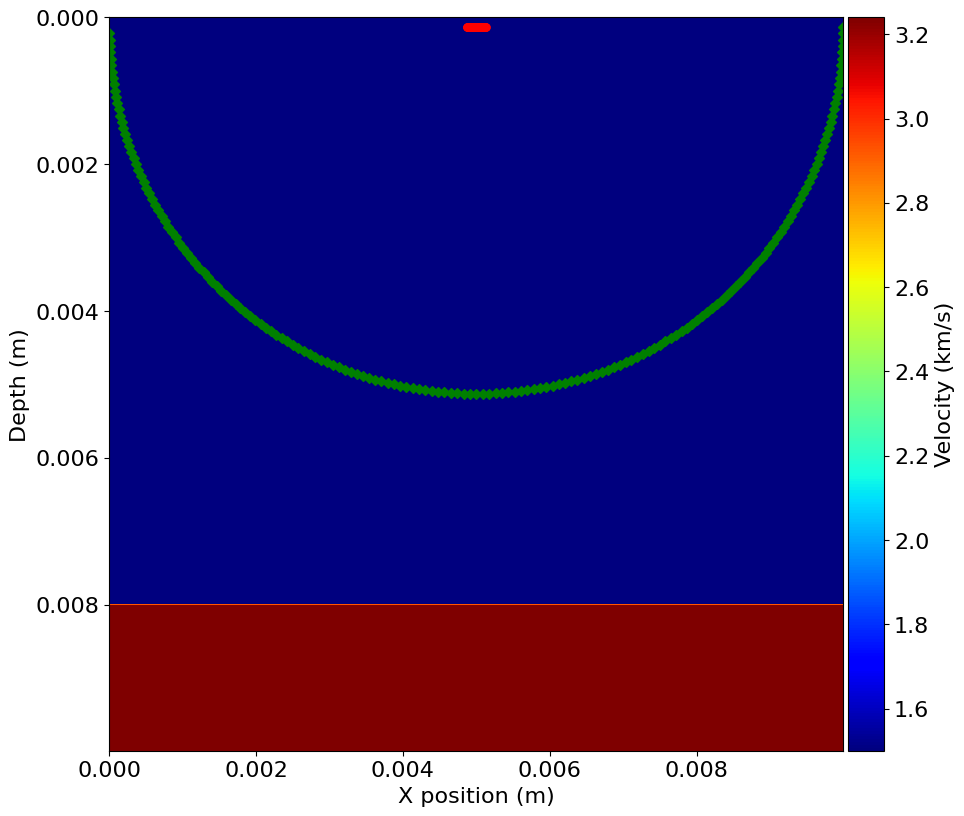

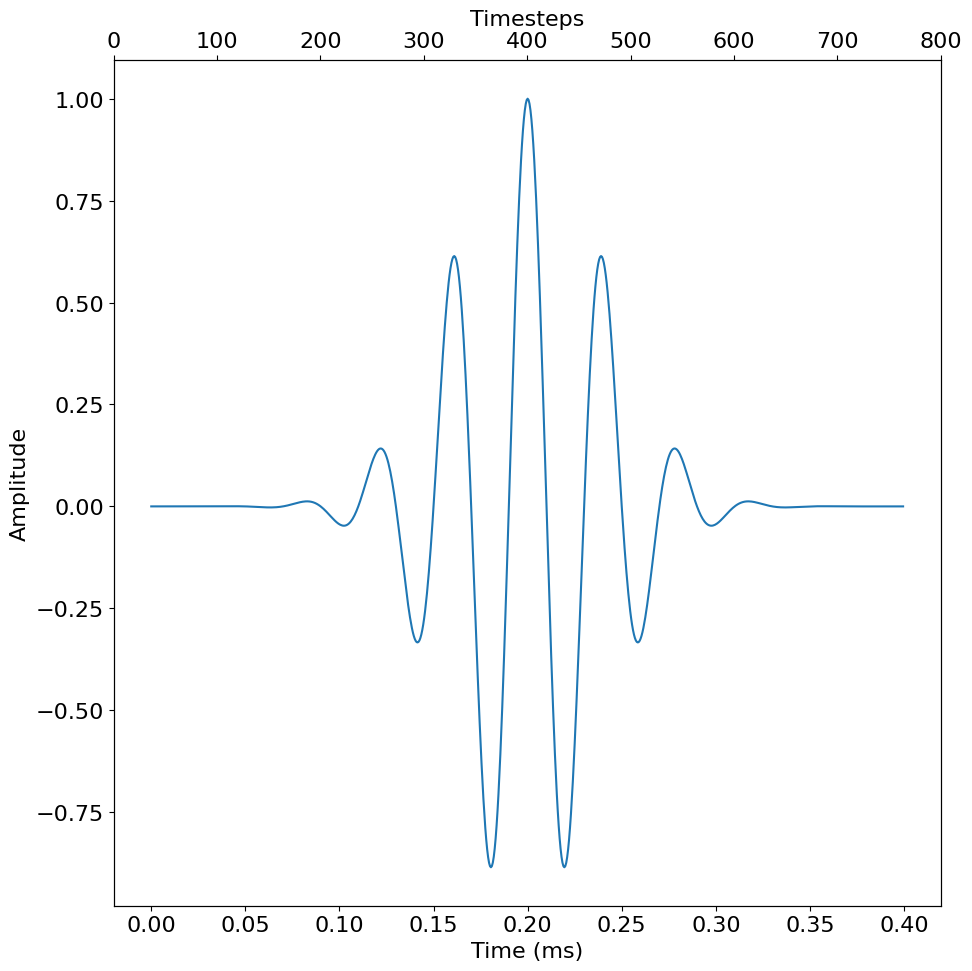

In [8]:
plot_velocity(
    sonars[45].model,
    source=sonars[45].src.coordinates.data,
    receiver=sonars[45].rec.coordinates.data,
)

plt.figure()
plt.plot(sonars[45].src.time_values[:800], sonars[45].src.signal_packet)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel("Timesteps")
plt.tight_layout()
plt.show()

In [8]:
recordings = {}
for a, s in sonars.items():
    recordings[a] = run_beam(
        s.src,
        s.rec,
        s.op,
        s.u,
        s.source_distance,
        s.time_range,
        s.model.critical_dt,
        a,
        v_env,
    )


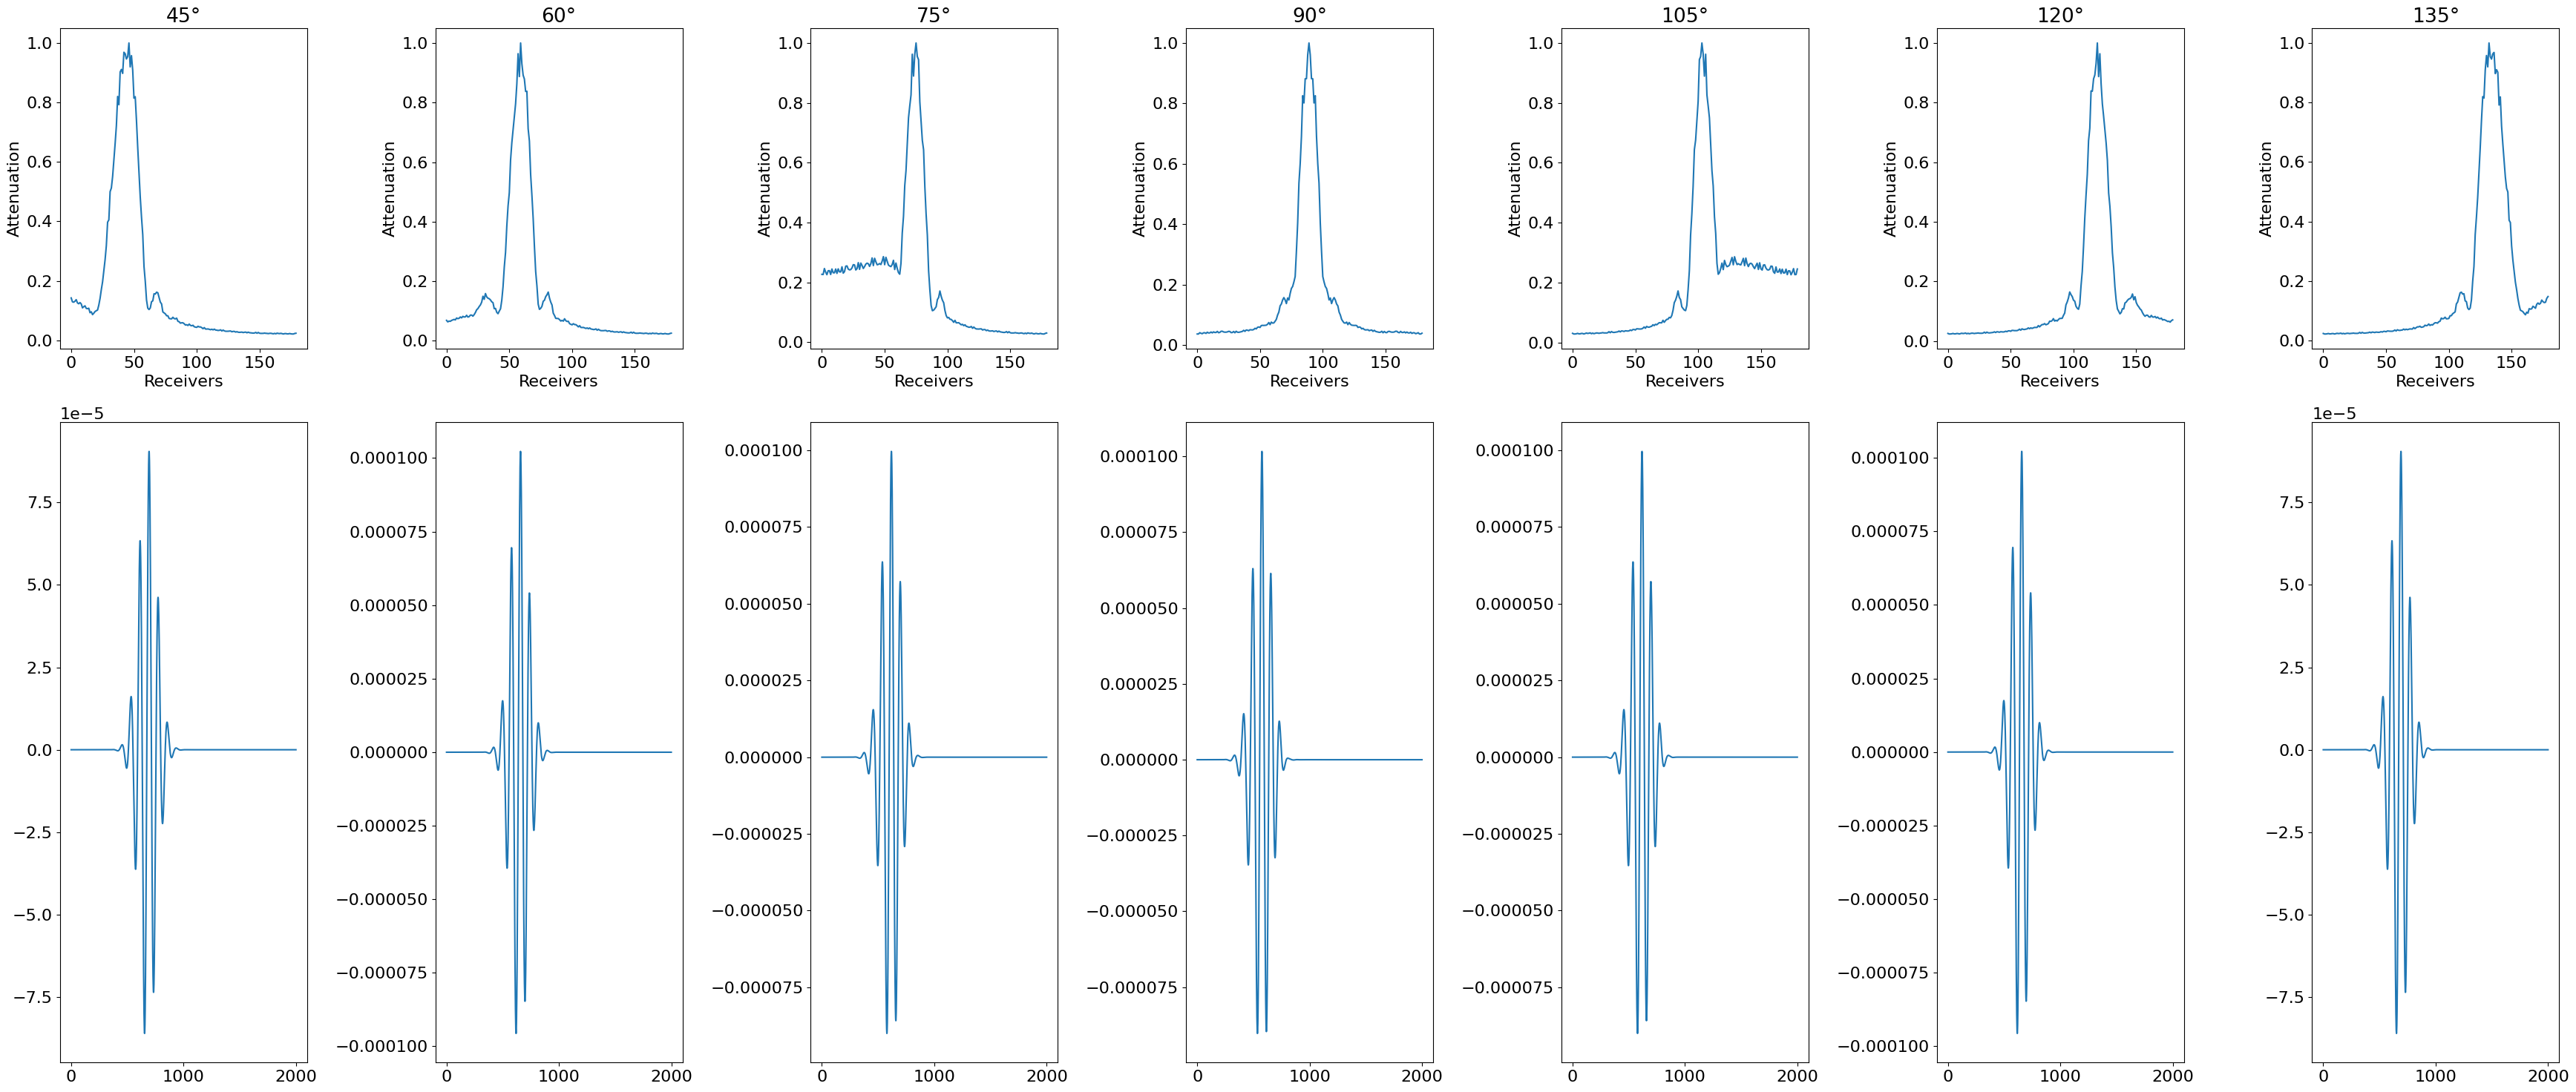

In [10]:
fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
for i, (a, r) in enumerate(recordings.items()):
    recording = np.flip(r)
    ax[0, i].plot(
        np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
    )
    ax[0, i].set_xlabel("Receivers")
    ax[0, i].set_ylabel("Attenuation")
    ax[0, i].set_title(f"{a}°")
    ax[0, i].tick_params()

    ax[1, i].plot(r[6500:8500, 180 - a])
fig.tight_layout()
plt.savefig("output/beamforming.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Ideal signal

In [11]:
domain_size = (20, 20)
distances = [0.25, 0.5, 0.75]
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20
source_distance = 0.002
v_env = 1.5


In [12]:
ideal_signals_90 = {}
snaps = {}
for d in distances:
    ideal_signals_90[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        90,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )


Operator `initdamp` generated in 0.47 s
  * lowering.Clusters: 0.22 s (47.3 %)
     * specializing.Clusters: 0.14 s (30.1 %)
  * lowering.IET: 0.19 s (40.8 %)
     * specializing.IET: 0.14 s (30.1 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.14 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 250.27 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 259.54 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 259.54 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.650748014450073 seconds


Operator `initdamp` generated in 0.50 s
  * lowering.Clusters: 0.24 s (48.4 %)
     * specializing.Clusters: 0.15 s (30.3 %)
  * lowering.IET: 0.19 s (38.3 %)
     * specializing.IET: 0.15 s (30.3 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.09 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 259.54 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 269.52 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.61930799484253 seconds


Operator `initdamp` generated in 0.50 s
  * lowering.Clusters: 0.23 s (46.9 %)
     * specializing.Clusters: 0.15 s (30.6 %)
  * lowering.IET: 0.19 s (38.7 %)
     * specializing.IET: 0.15 s (30.6 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.09 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 269.52 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 291.98 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.623666048049927 seconds


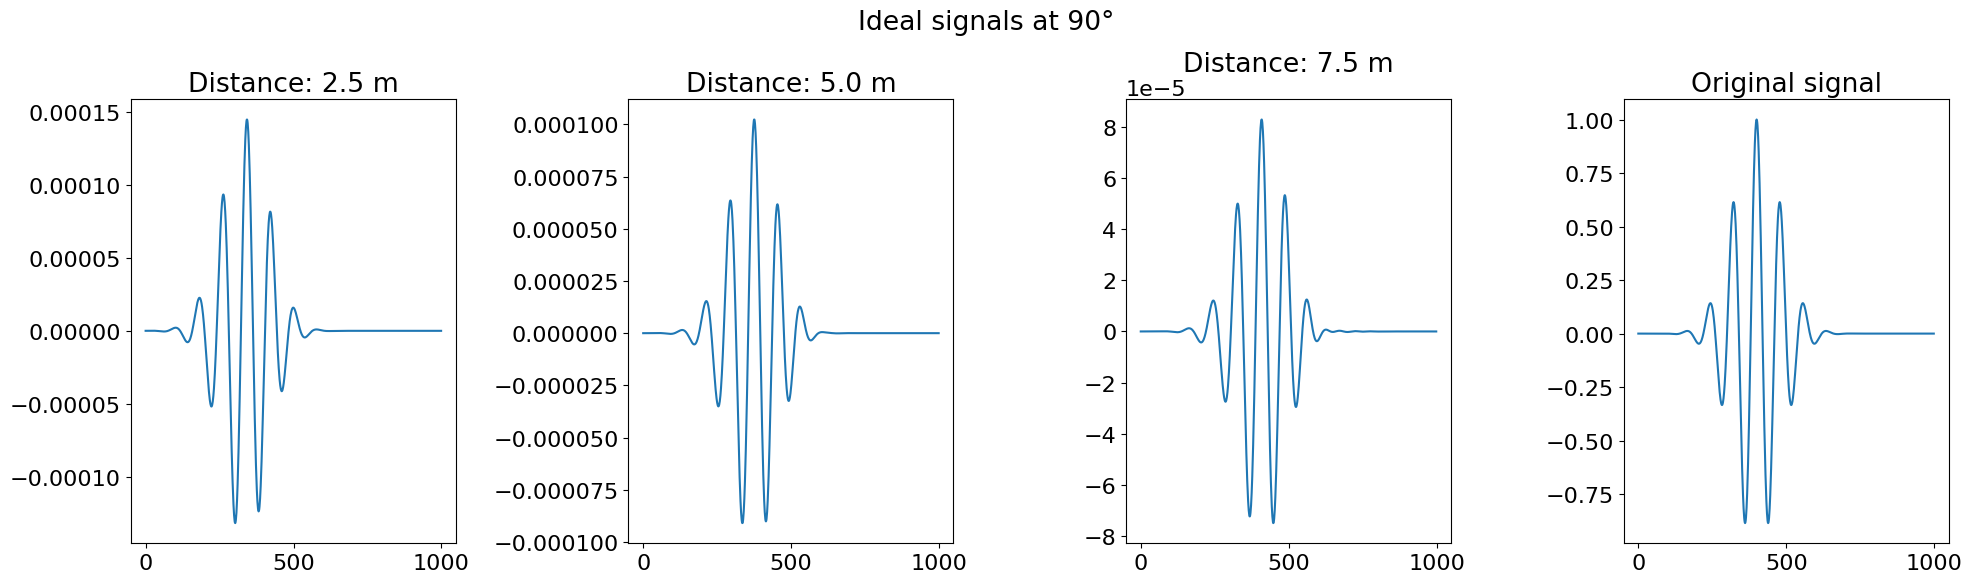

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Ideal signals at 90°")
ax[0].plot(ideal_signals_90[0.25][3400:4400])
ax[0].set_title(f"Distance: {distances[0] * 20 / 2} m")
ax[1].plot(ideal_signals_90[0.5][6700:7700])
ax[1].set_title(f"Distance: {distances[1] * 20 / 2} m")
ax[2].plot(ideal_signals_90[0.75][10000:11000])
ax[2].set_title(f"Distance: {distances[2] * 20 / 2} m")
ax[3].plot(src.data[:1000, 0])
ax[3].set_title(f"Original signal")
fig.tight_layout()
plt.savefig("ideal_signals_90.pdf", bbox_inches="tight", dpi=600, format="pdf")

In [14]:
ideal_signals_45 = {}
for d in distances:
    ideal_signals_45[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        45,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )


Operator `initdamp` generated in 0.46 s
  * lowering.Clusters: 0.21 s (46.0 %)
     * specializing.Clusters: 0.14 s (30.7 %)
  * lowering.IET: 0.18 s (39.5 %)
     * specializing.IET: 0.14 s (30.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 212.35 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.629277467727661 seconds


Operator `initdamp` generated in 0.50 s
  * lowering.Clusters: 0.24 s (48.8 %)
     * specializing.Clusters: 0.15 s (30.5 %)
  * lowering.IET: 0.19 s (38.7 %)
     * specializing.IET: 0.14 s (28.5 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 304.67 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 291.98 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 10.652227401733398 seconds


Operator `initdamp` generated in 0.50 s
  * lowering.Clusters: 0.23 s (47.0 %)
     * specializing.Clusters: 0.15 s (30.6 %)
  * lowering.IET: 0.19 s (38.8 %)
     * specializing.IET: 0.14 s (28.6 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.08 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.31, 0.94 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section2<254,2508> ran in 0.01 s [OI=0.69, 269.52 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,2508> ran in 0.01 s [OI=0.69, 269.52 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<2508,254> ran in 0.01 s [OI=0.69, 280.30 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

Simulation took 11.370994329452515 seconds


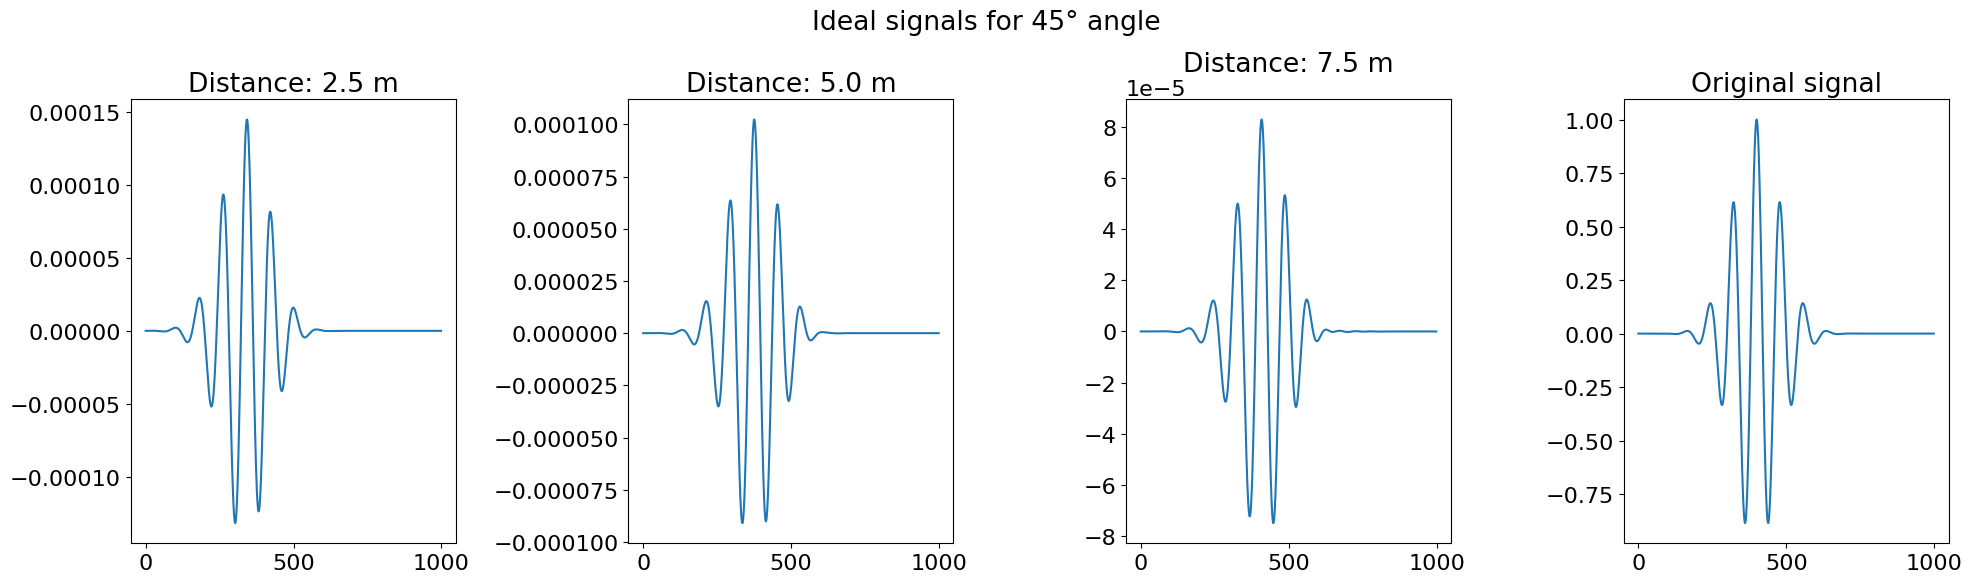

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Ideal signals for 45° angle")
ax[0].plot(ideal_signals_90[0.25][3400:4400])
ax[0].set_title(f"Distance: {distances[0] * 20 / 2} m")
ax[1].plot(ideal_signals_90[0.5][6700:7700])
ax[1].set_title(f"Distance: {distances[1] * 20 / 2} m")
ax[2].plot(ideal_signals_90[0.75][10000:11000])
ax[2].set_title(f"Distance: {distances[2] * 20 / 2} m")
ax[3].plot(src.data[:1000, 0])
ax[3].set_title(f"Original signal")
fig.tight_layout()
# save the figure as pdf
plt.savefig("ideal_signals_45.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Detection with correlation

In [24]:
domain_size = (60, 30)
radius = 28
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 250
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20


In [25]:
sonar = Sonar(
    domain_size,
    f0,
    v_env,
    EllipsisBottom(True),
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.finalize()

51it [00:34,  1.47it/s]
Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.16 s (45.4 %)
     * specializing.Clusters: 0.11 s (31.3 %)
  * lowering.IET: 0.14 s (39.8 %)
     * specializing.IET: 0.11 s (31.3 %)
Flops reduction after symbolic optimization: [72 --> 72]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/c3822be91626786ab39ee018badf5094342ff061.cpp -lm -o /tmp/devito-jitcache-uid543800090/c3822be91626786ab39ee018badf5094342ff061.so


nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.
Operator `initdamp` jit-compiled `/tmp/devito-jitcache-uid543800090/c3822be91626786ab39ee018badf5094342ff061.cpp` in 6.14 s with `NvidiaCompiler`
Operator `initdamp` ran in 0.77 s
Global performance: [OI=0.22, 1.82 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<1270> ran in 0.01 s [OI=0.88, 0.81 GFlops/s, 0.00 GPts/s]
  * section2<1270,17540> ran in 0.01 s [OI=0.69, 720.69 GFlops/s, 0.00 GPts/s]
  * section3<1270> ran in 0.01 s [OI=0.88, 0.99 GFlops/s, 0.00 GPts/s]
  * section4<1270,17540> ran in 0.01 s [OI=0.69, 862.80 GFlops/s, 0.00 GPts/s]
  * section5<1270> ran in 0.01 s [OI=0.88, 0.99 GFlops/s, 0.00 GPts/s]
  * section6<32540,1270> ran in 0.01 s [OI=0.69, 746.45 GFlops/s, 0.00 GPts/s]
  * section7<1270> ran in 0.01 s [OI=0.88, 1.12 GFlops/s, 0.00 GPts/s]
  * section8<32540,1270> ran in 0.01 s [OI=0.69, 752.63 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'devi

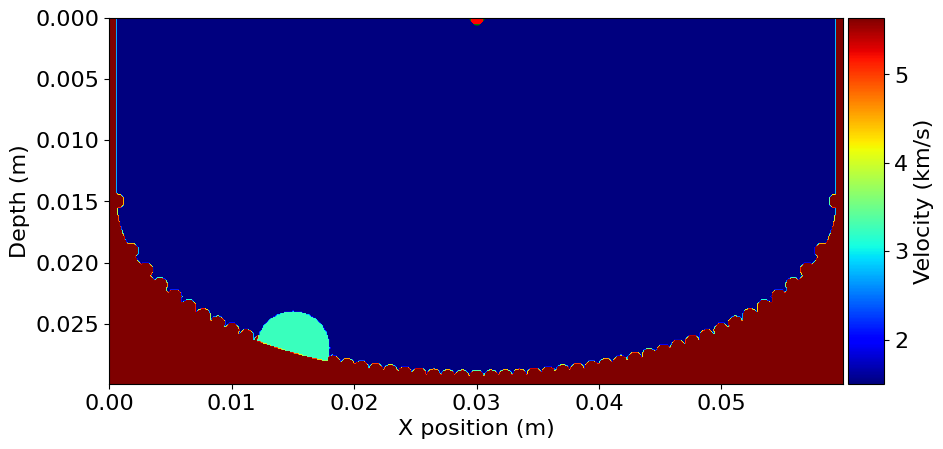

In [32]:
plot_velocity(
    sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
)

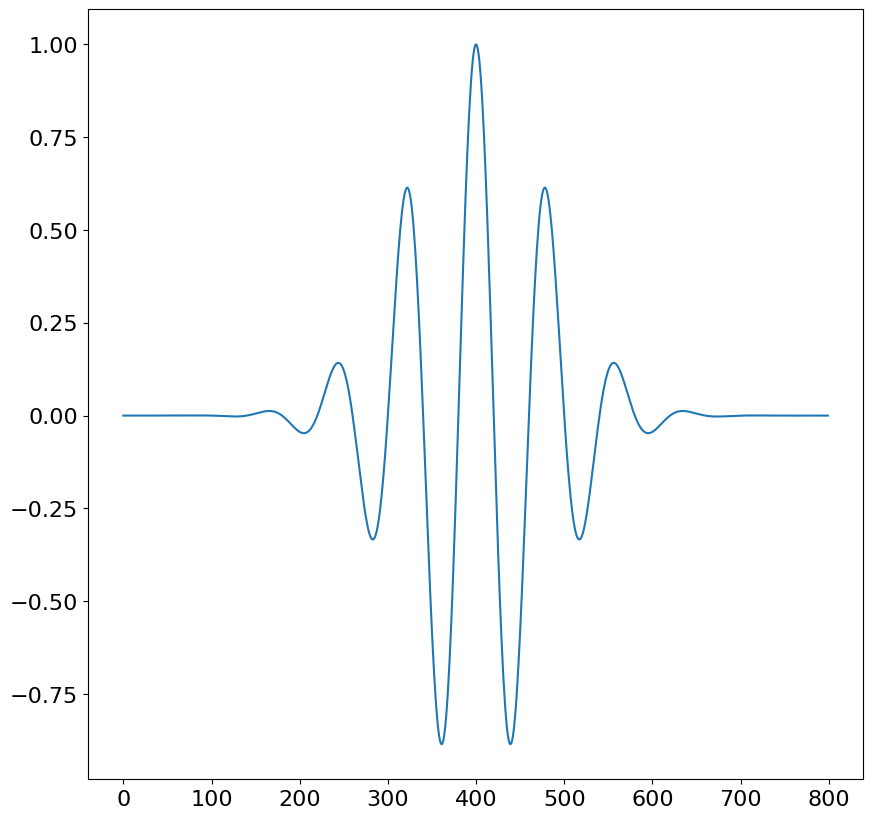

In [19]:
ideal_signal = sonar.src.signal_packet
plt.plot(ideal_signal)
plt.show()


In [26]:
recording_45 = run_beam(
    sonar.src,
    sonar.rec,
    sonar.op,
    sonar.u,
    sonar.source_distance,
    sonar.time_range,
    sonar.model.critical_dt,
    45,
    v_env,
)

Allocating host memory for u(3, 32556, 17556) [13 GB]
Allocating host memory for rec(615687, 128) [601 MB]


nvc++ -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800090/2f0c011349986cba480daa6decee44dc13d30576.cpp -lm -o /tmp/devito-jitcache-uid543800090/2f0c011349986cba480daa6decee44dc13d30576.so


nvc++-Warning-CUDA_HOME has been deprecated. Please, use NVHPC_CUDA_HOME instead.
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800090/2f0c011349986cba480daa6decee44dc13d30576.cpp` in 6.18 s with `NvidiaCompiler`


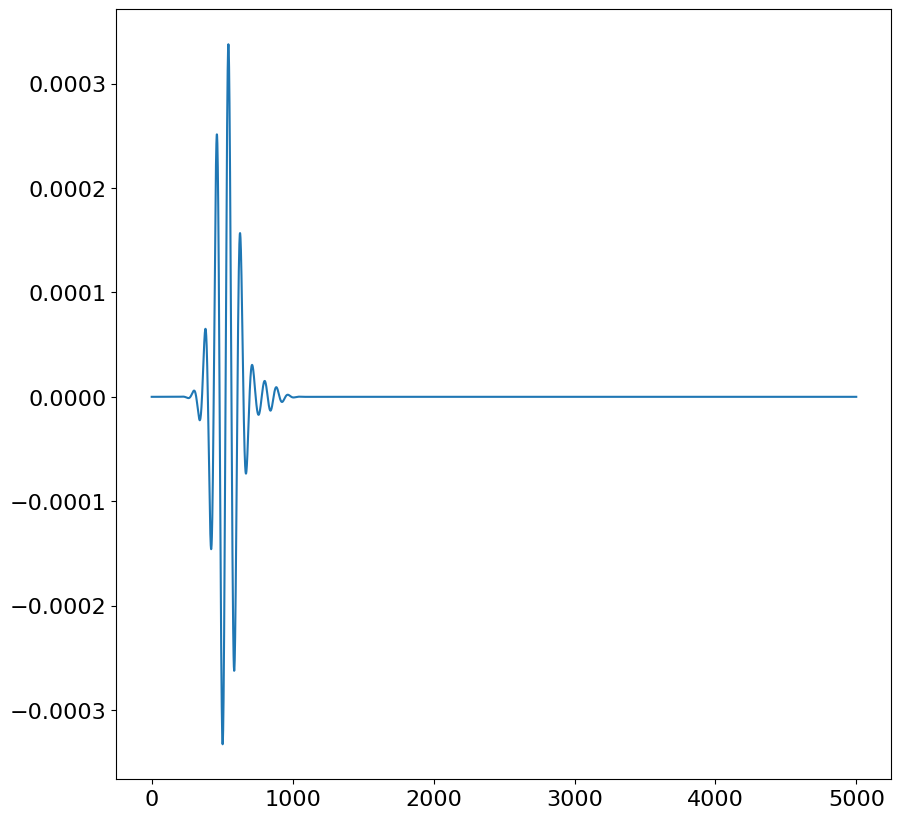

In [21]:
plt.plot(recording_45[:5000, 64])
start_time = np.argmax(recording_45[:5000, 64])


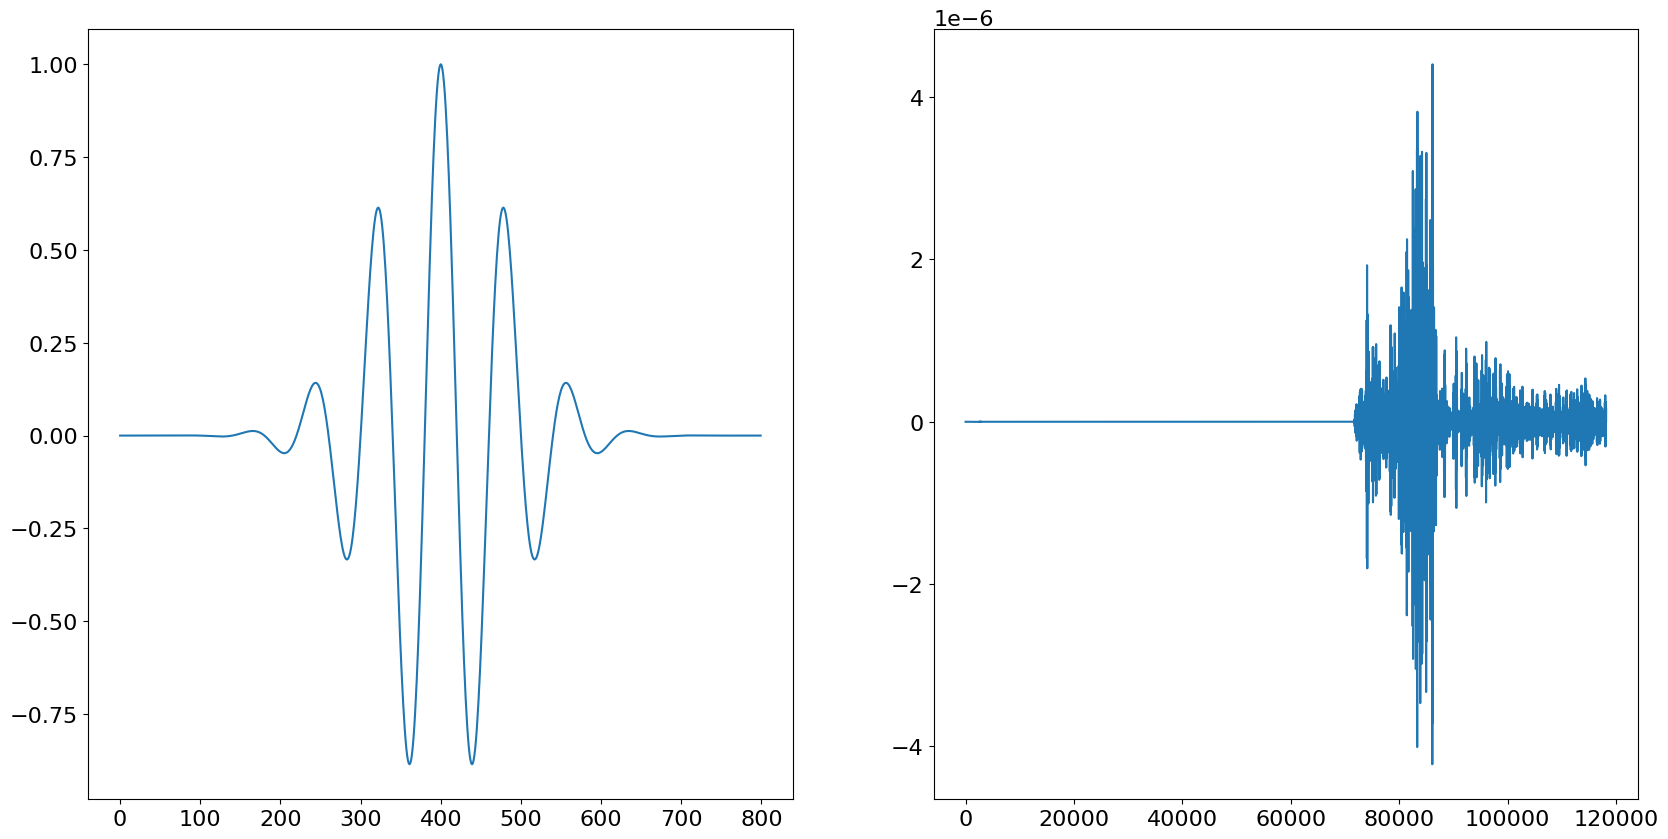

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(ideal_signal)
ax[1].plot(recording_45[5000:, 64])
plt.savefig("output/correlation_ideal_recording.pdf", bbox_inches="tight", dpi=600, format="pdf")

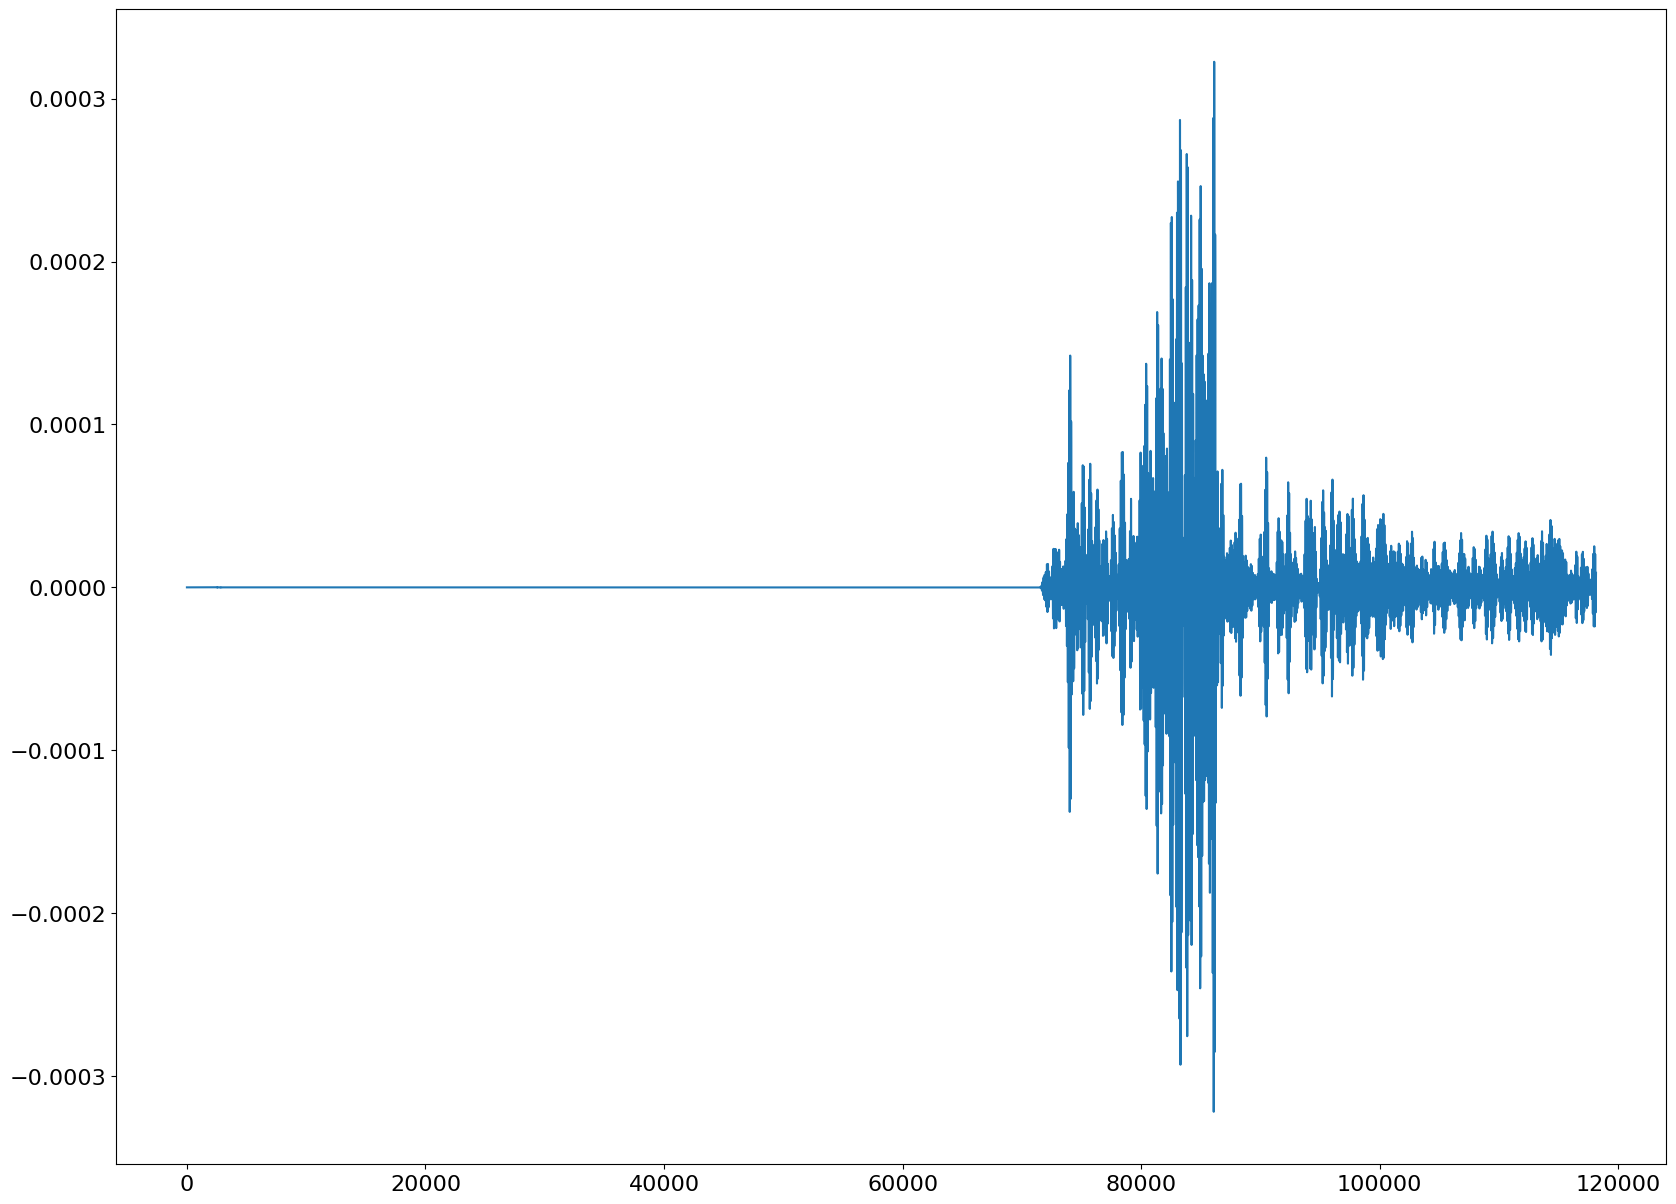

86127


In [23]:
correlate = np.correlate(recording_45[5000:, 64], ideal_signal, mode="same")
plt.figure(figsize=(20, 15))
plt.plot(correlate)
plt.show()
print(np.argmax(correlate))

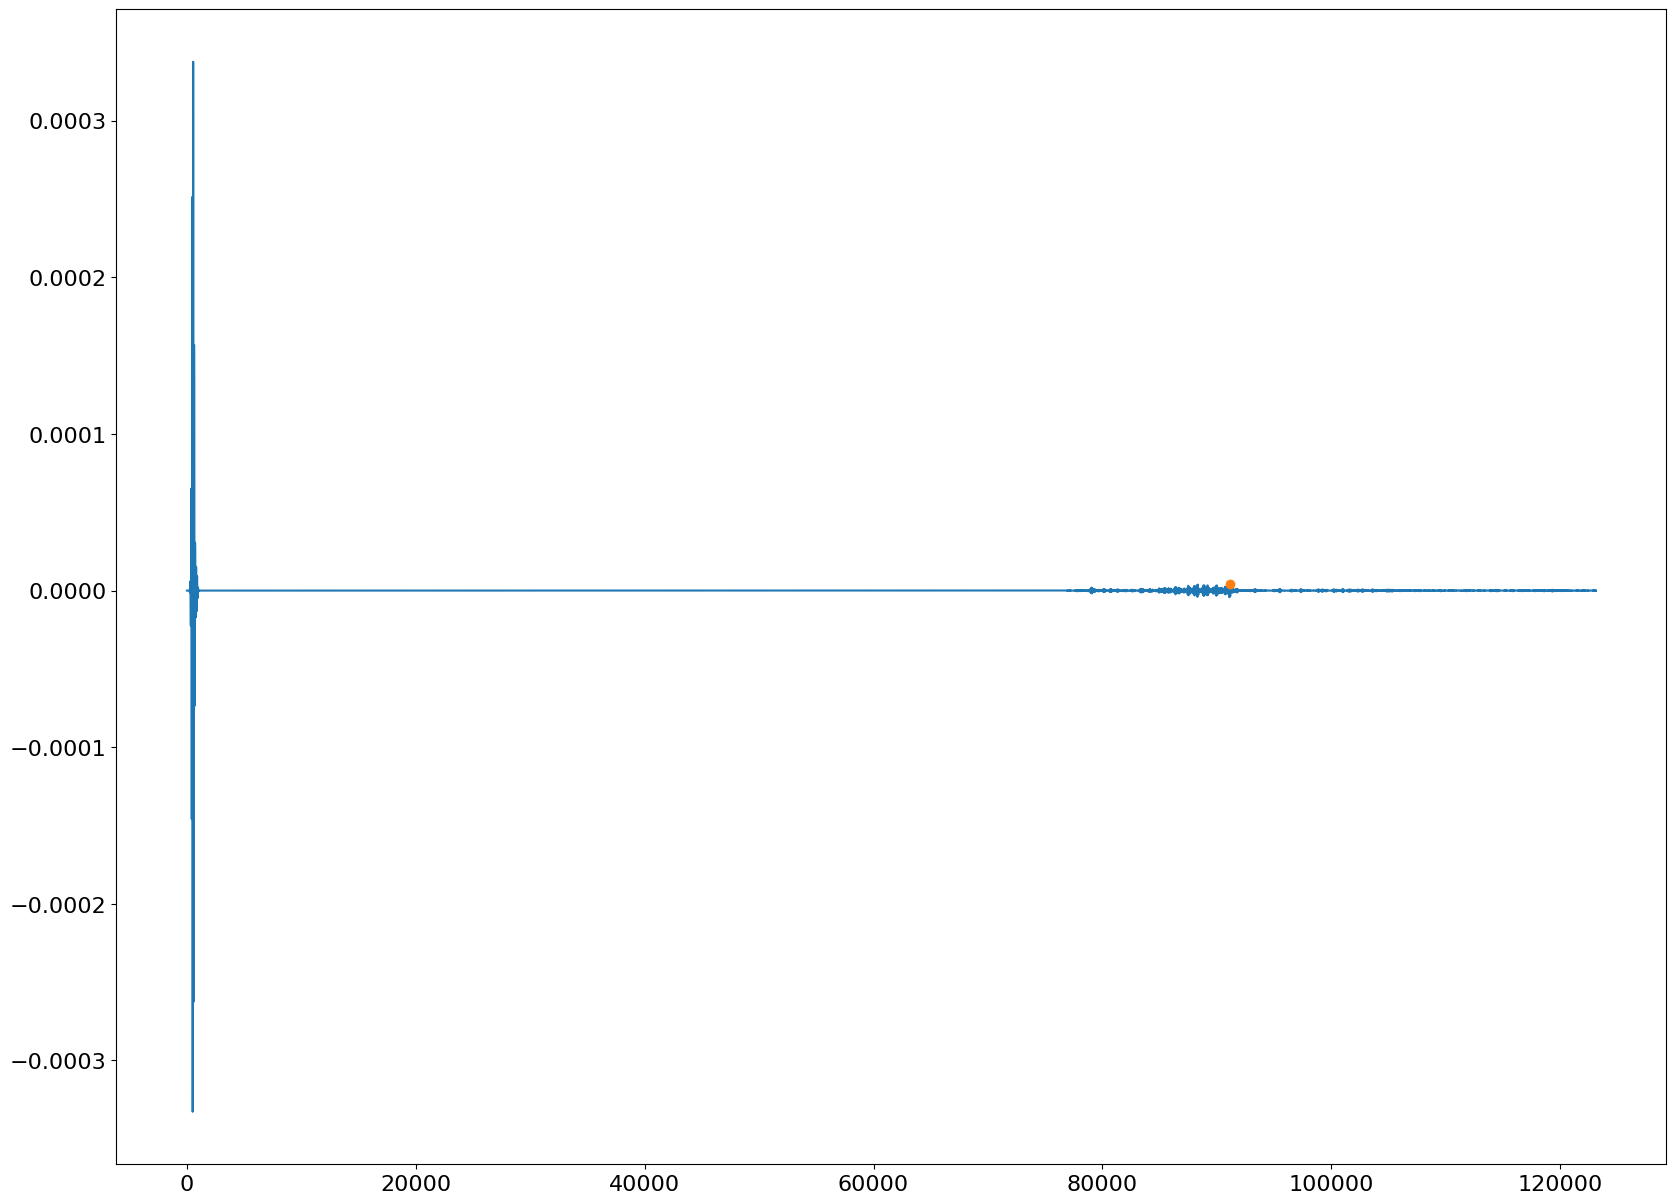

<Figure size 1000x1000 with 0 Axes>

In [24]:
peak = 5000 + correlate.argmax()
## change the figure size
plt.figure(figsize=(20, 15))
plt.plot(recording_45[:, 64])
plt.plot(peak, recording_45[peak, 64], "o")
plt.show()
plt.savefig("output/correlate.pdf", bbox_inches="tight", dpi=600, format="pdf")

In [25]:
distance = (peak - start_time) * sonar.model.critical_dt * v_env / 2
print(f"Distance: {distance} m")


Distance: 33.968625 m


### Detect multiple angles

In [5]:
domain_size = (60, 30)
v_env = 1.5
ns = 128
source_distance = 0.002
f0 = 100
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20
angles = [30, 45, 60, 75, 90, 105, 120, 135, 150]


In [11]:
obstacle = True
v_wall = 5.64
v_obj = 3.24
domain_dims = (
    round(domain_size[0] / spatial_dist),
    round(domain_size[1] / spatial_dist),
)
vp = np.full(domain_dims, v_env, dtype=np.float32)
r_obs = vp.shape[0] / 20
a, b = vp.shape[0] / 4, vp.shape[1] - r_obs
y, x = np.ogrid[-a : vp.shape[0] - a, -b : vp.shape[1] - b]
vp[x * x + y * y <= r_obs * r_obs] = v_obj
nx = domain_dims[0]
nz = domain_dims[1]
wall = round(nx * 0.02)
offs = round(wall / 2)
a = round((nx - wall) / 2)
b = round((nz - wall) / 2)
offs = round(wall / 2)
x = np.arange(0, vp.shape[0])
y = np.arange(0, vp.shape[1])
if obstacle:
    r = vp.shape[0] / 100
    ox = np.arange(offs, 2 * a + offs + 1, 2 * a / 50)
    oy = np.sqrt(1 - (ox - a - offs) ** 2 / a**2) * b + offs + b
    for oxx, oyy in tqdm.tqdm(zip(ox, oy)):
        mask = (y[np.newaxis, :] - oyy) ** 2 + (
            x[:, np.newaxis] - oxx
        ) ** 2 < r**2
        vp[mask] = v_wall
mask = (y[np.newaxis, :] - offs - b) ** 2 / b**2 + (
    x[:, np.newaxis] - offs - a
) ** 2 / a**2 > 1
vp[mask] = v_wall
vp[offs:-offs, :b] = v_env

51it [00:01, 29.53it/s]


In [12]:
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        vp,
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}
for _, v in sonars.items():
    v.set_source()
    v.finalize()

Operator `initdamp` generated in 0.35 s
  * lowering.Clusters: 0.16 s (46.1 %)
     * specializing.Clusters: 0.10 s (28.8 %)
  * lowering.IET: 0.14 s (40.3 %)
     * specializing.IET: 0.11 s (31.7 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/67213697f431dcabdbe9ec83ea71a4399a1b9618.cpp` in 0.07 s from jit-cache
Operator `initdamp` ran in 0.04 s
Global performance: [OI=0.22, 1.40 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2<254,3508> ran in 0.01 s [OI=0.69, 297.02 GFlops/s, 0.00 GPts/s]
  * section3<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4<254,3508> ran in 0.01 s [OI=0.69, 326.72 GFlops/s, 0.00 GPts/s]
  * section5<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section6<6508,254> ran in 0.01 s [OI=0.69, 466.24 GFlops/s, 0.00 GPts/s]
  * section7<254> ran in 0.01 s [OI=0.88

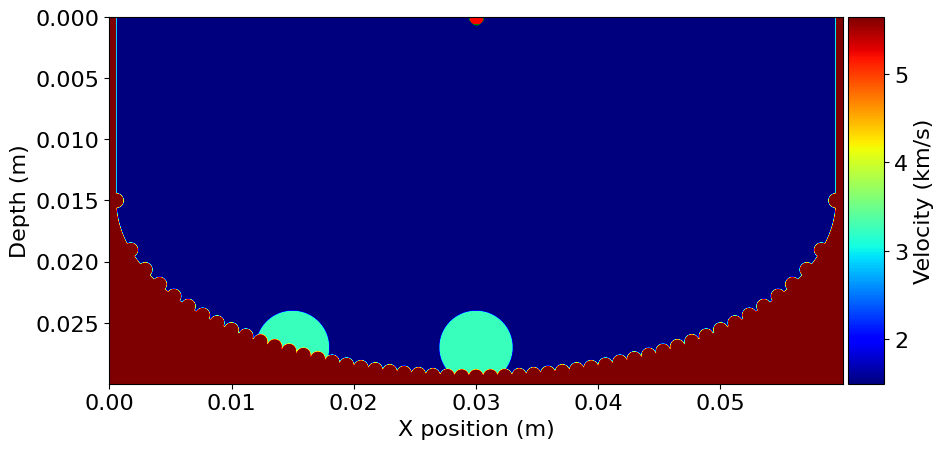

In [13]:
plot_velocity(sonars[45].model, source=sonars[45].src.coordinates.data, receiver=sonars[45].rec.coordinates.data)

In [14]:
ideal_signal = sonars[45].src.signal_packet

In [15]:
recordings = {
    a: run_beam(
        sonars[a].src,
        sonars[a].rec,
        sonars[a].op,
        sonars[a].u,
        sonars[a].source_distance,
        sonars[a].time_range,
        sonars[a].model.critical_dt,
        a,
        v_env,
    )
    for a in angles
}

Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 102.96 s
Global performance: [OI=1.28, 1119.55 GFlops/s, 27.31 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 100.03 s [OI=1.28, 1152.32 GFlops/s, 28.11 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.49 s [OI=8.44, 2.87 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.28 s [OI=10.75, 3.19 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 103.40421462059021 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.22 s
Global performance: [OI=1.28, 1106.02 GFlops/s, 26.98 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.25 s [OI=1.28, 1138.44 GFlops/s, 27.77 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.49 s [OI=8.44, 2.87 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.32 s [OI=10.75, 3.10 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.66115236282349 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.44 s
Global performance: [OI=1.28, 1103.69 GFlops/s, 26.92 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.47 s [OI=1.28, 1136.00 GFlops/s, 27.71 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.51 s [OI=8.44, 2.83 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.31 s [OI=10.75, 3.13 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.87786865234375 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.53 s
Global performance: [OI=1.28, 1102.74 GFlops/s, 26.90 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.55 s [OI=1.28, 1135.07 GFlops/s, 27.69 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.50 s [OI=8.44, 2.85 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.32 s [OI=10.75, 3.09 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.96450805664062 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.54 s
Global performance: [OI=1.28, 1102.63 GFlops/s, 26.90 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.56 s [OI=1.28, 1134.98 GFlops/s, 27.69 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.52 s [OI=8.44, 2.81 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.31 s [OI=10.75, 3.13 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.9793951511383 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.54 s
Global performance: [OI=1.28, 1102.63 GFlops/s, 26.90 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.56 s [OI=1.28, 1134.93 GFlops/s, 27.69 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.50 s [OI=8.44, 2.86 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.32 s [OI=10.75, 3.09 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 104.97788763046265 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.56 s
Global performance: [OI=1.28, 1102.42 GFlops/s, 26.89 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.59 s [OI=1.28, 1134.65 GFlops/s, 27.68 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.51 s [OI=8.44, 2.83 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.31 s [OI=10.75, 3.13 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 105.00653767585754 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.63 s
Global performance: [OI=1.28, 1101.68 GFlops/s, 26.87 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.65 s [OI=1.28, 1133.94 GFlops/s, 27.66 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.50 s [OI=8.44, 2.86 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.32 s [OI=10.75, 3.09 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 105.06915831565857 seconds


Allocating host memory for u(3, 6524, 3524) [526 MB]
Allocating host memory for rec(123139, 128) [120 MB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/144ad251e5ee0ab426a694bae5bf7af16743bfd8.cpp` in 0.10 s from jit-cache
Operator `Kernel` ran in 104.69 s
Global performance: [OI=1.28, 1101.05 GFlops/s, 26.86 GPts/s]
Local performance:
  * section0<123137,6508,3508> ran in 101.71 s [OI=1.28, 1133.29 GFlops/s, 27.65 GPts/s]
  * section1<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.52 s [OI=8.44, 2.82 GFlops/s, 0.02 GPts/s]
  * section2<<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>,<123137,128>> ran in 1.31 s [OI=10.75, 3.13 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 105.1331741809845 seconds


In [16]:
cords = np.zeros((np.size(angles), 2))
for a, v in recordings.items():
    coordinates = np.zeros((128, 2))
    for i in range(128):
        start_time = np.argmax(recordings[a][:5000, i])
        correlate = np.correlate(recordings[a][5000:, i], ideal_signal, mode="same")
        peak = 5000 + correlate.argmax()
        distance = (
            peak - start_time
        ) * sonars[a].model.critical_dt * v_env / 2
        rec_coords = sonars[a].rec.coordinates.data[i]
        coordinates[i, 0] = rec_coords[0] - distance * np.cos(np.deg2rad(a))
        coordinates[i, 1] = rec_coords[1] + distance * np.sin(np.deg2rad(a))
        cords[a // 15 - 2, :] = np.mean(coordinates, axis=0)
        

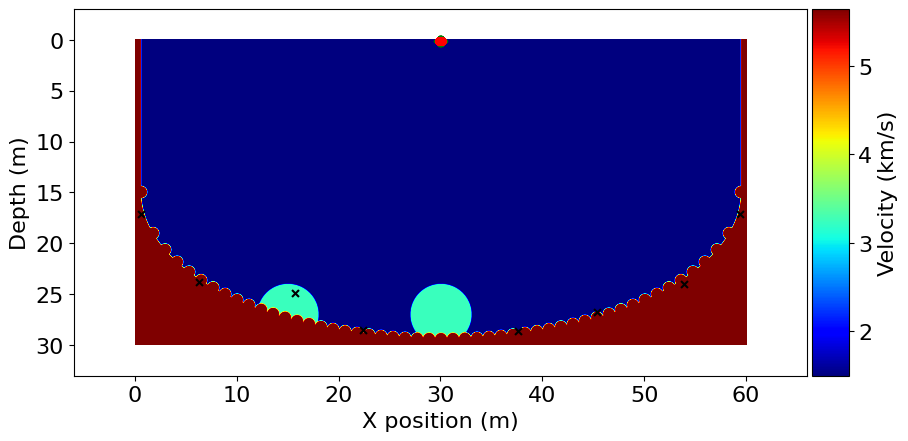

In [17]:
compare_velocity_to_measure(sonars[45].model, cords, sonars[45].src.coordinates.data, sonars[45].rec.coordinates.data)

### Snapshot

In [5]:
domain_size = (60, 30)
v_env = 1.5
source_distance = 0.002
ns = 128
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 5
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20


In [6]:
obstacle = True
v_wall = 5.64
v_obj = 3.24
domain_dims = (
    round(domain_size[0] / spatial_dist),
    round(domain_size[1] / spatial_dist),
)
vp = np.full(domain_dims, v_env, dtype=np.float32)
r_obs = vp.shape[0] / 20
a, b = vp.shape[0] / 4, vp.shape[1] - r_obs
y, x = np.ogrid[-a : vp.shape[0] - a, -b : vp.shape[1] - b]
vp[x * x + y * y <= r_obs * r_obs] = v_obj
nx = domain_dims[0]
nz = domain_dims[1]
wall = round(nx * 0.02)
offs = round(wall / 2)
a = round((nx - wall) / 2)
b = round((nz - wall) / 2)
offs = round(wall / 2)
x = np.arange(0, vp.shape[0])
y = np.arange(0, vp.shape[1])
if obstacle:
    r = vp.shape[0] / 100
    ox = np.arange(offs, 2 * a + offs + 1, 2 * a / 50)
    oy = np.sqrt(1 - (ox - a - offs) ** 2 / a**2) * b + offs + b
    for oxx, oyy in tqdm.tqdm(zip(ox, oy)):
        mask = (y[np.newaxis, :] - oyy) ** 2 + (
            x[:, np.newaxis] - oxx
        ) ** 2 < r**2
        vp[mask] = v_wall
mask = (y[np.newaxis, :] - offs - b) ** 2 / b**2 + (
    x[:, np.newaxis] - offs - a
) ** 2 / a**2 > 1
vp[mask] = v_wall
vp[offs:-offs, :b] = v_env

51it [00:00, 5022.29it/s]


In [7]:
sonar = Sonar(
    domain_size,
    f0,
    v_env,
    vp,
    source_distance=source_distance,
    ns=ns,
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.finalize(snapshot_delay=0.1)

Operator `initdamp` generated in 0.36 s
  * lowering.Clusters: 0.16 s (45.0 %)
     * specializing.Clusters: 0.10 s (28.1 %)
  * lowering.IET: 0.14 s (39.4 %)
     * specializing.IET: 0.11 s (30.9 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800090/e9e25937125eaad53e566e64dc7da769a5a27f54.cpp` in 0.07 s from jit-cache
Operator `initdamp` ran in 5.06 s
Global performance: [OI=0.22, 0.01 GFlops/s]
Local performance:
  * section0<> ran in 0.01 s 
  * section1<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section2<25,350> ran in 0.01 s [OI=0.69, 6.88 GFlops/s, 0.00 GPts/s]
  * section3<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section4<25,350> ran in 0.01 s [OI=0.69, 7.41 GFlops/s, 0.00 GPts/s]
  * section5<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s, 0.00 GPts/s]
  * section6<650,25> ran in 0.01 s [OI=0.69, 13.76 GFlops/s, 0.00 GPts/s]
  * section7<25> ran in 0.01 s [OI=0.88, 0.02 GFlops/s

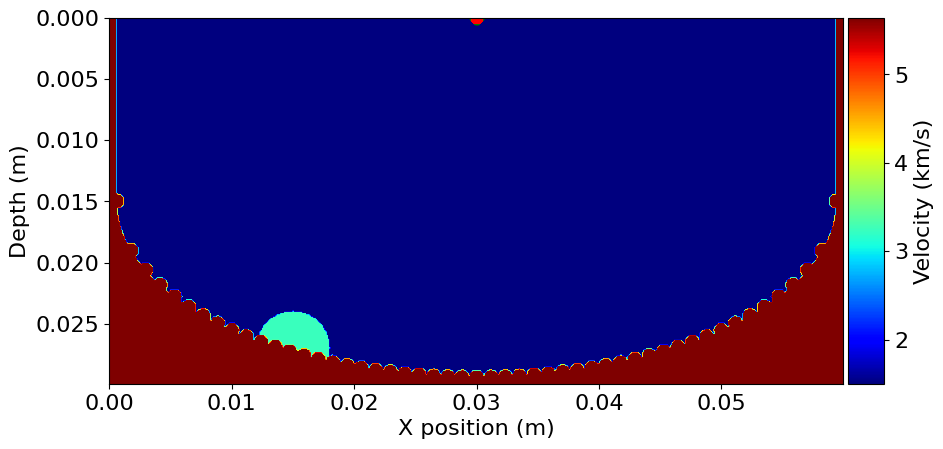

In [8]:
plot_velocity(
    sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data
)

In [9]:
recording = run_beam(
    sonar.src,
    sonar.rec,
    sonar.op,
    sonar.u,
    source_distance,
    sonar.time_range,
    sonar.model.critical_dt,
    45,
    v_env,
)

Allocating host memory for u(3, 666, 366) [6 MB]
Allocating host memory for rec(12315, 128) [12 MB]


Allocating host memory for usave(616, 666, 366) [1 GB]
Operator `Kernel` fetched `/tmp/devito-jitcache-uid543800090/7bdbad0a8a1cab6c50576c107302d9d7bbd2c26f.cpp` in 0.20 s from jit-cache
Operator `Kernel` ran in 0.72 s
Global performance: [OI=0.85, 160.67 GFlops/s, 3.90 GPts/s]
Local performance:
  * section0<12313,650,350> ran in 0.24 s [OI=1.26, 484.38 GFlops/s, 11.82 GPts/s]
  * section1<> ran in 0.01 s 
  * section2<<12313,128>,<12313,128>,<12313,128>,<12313,128>,<12313,128>> ran in 0.14 s [OI=8.44, 3.06 GFlops/s, 0.02 GPts/s]
  * section3<<12313,128>,<12313,128>,<12313,128>,<12313,128>,<12313,128>,<12313,128>> ran in 0.13 s [OI=10.75, 3.31 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}


Simulation took 1.1008450984954834 seconds


In [10]:
plot_snapshot_and_signal(
    sonar.usave.data,
    recording[:, 64],
    sonar.model,
    f"output/snapshot.gif",
    sonar.src.coordinates.data,
    sonar.rec.coordinates.data,
)

MovieWriter ffmpeg unavailable; using Pillow instead.
